In [1]:
import os

os.chdir("../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import shapely
from shapely.geometry import Point
import cartopy.crs as ccrs
import geopandas as gpd
import contextily as ctx
import folium

import networkx as nx

In [2]:
AIRPORT_PATH = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
AIRLINE_PATH = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat"
ROUTE_PATH = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"

airport_cols = [
    "Airport ID", "Name", "City", "Country", "IATA", "ICAO", "Latitude",
    "Longitude", "Altitude", "Timezone", "DST", "Tz database", "Type", "Source"
]

airline_cols = [
    "Airline ID", "Name", "Alias", "IATA", "ICAO", "Callsign", "Country",
    "Active"
]

route_cols = [
    "Airline", "Airline ID", "Source airport", "Source airport ID",
    "Destination airport", "Destination airport ID", "Codeshare", "Stops",
    "Equipment"
]

In [3]:
def load_data(path: str, cols: list) -> pd.DataFrame:
    df = pd.read_csv(path, sep=",", header=None).replace(r"\N", np.nan).replace(r"-", np.nan)
    df.columns = [col.lower().replace(" ", "_") for col in cols]
    return df

In [4]:
airport_df = load_data(AIRPORT_PATH, airport_cols)
airline_df = load_data(AIRLINE_PATH, airline_cols)

In [5]:
airport_keys = airport_df.iata.tolist()
airport_geoms = [
    Point(x, y) for x, y in zip(airport_df.longitude, airport_df.latitude)
]
airport_dict = dict(zip(airport_keys, airport_geoms))

In [6]:
route_df = load_data(ROUTE_PATH, route_cols).drop(["codeshare", "equipment"],
                                                  axis=1)
route_df["source_geom"] = route_df["source_airport"].map(airport_dict)
route_df["destination_geom"] = route_df["destination_airport"].map(
    airport_dict)
route_df = (route_df.dropna().reset_index().drop("index", axis=1))

In [7]:
from math import radians, cos, sin, asin, sqrt

def calculate_distance(point1: shapely.geometry.Point,
                       point2: shapely.geometry.Point) -> float:
    """
    The function is to calculate the distance in Kilometers between any two given coordinates.
    """
    lon1, lon2 = radians(point1.x), radians(point2.x)
    lat1, lat2 = radians(point1.y), radians(point2.y)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))

    r = 6371

    return (c * r)

route_df["distance"] = [
    calculate_distance(pt1, pt2)
    for pt1, pt2 in zip(route_df.source_geom, route_df.destination_geom)
]
route_df.head(5)

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,stops,source_geom,destination_geom,distance
0,2B,410,AER,2965,KZN,2990,0,POINT (39.9566 43.449902),POINT (49.278701782227 55.606201171875),1506.825604
1,2B,410,ASF,2966,KZN,2990,0,POINT (48.0063018799 46.2832984924),POINT (49.278701782227 55.606201171875),1040.438320
2,2B,410,ASF,2966,MRV,2962,0,POINT (48.0063018799 46.2832984924),POINT (43.08190155029297 44.225101470947266),448.164909
3,2B,410,CEK,2968,KZN,2990,0,POINT (61.5033 55.305801),POINT (49.278701782227 55.606201171875),770.508500
4,2B,410,CEK,2968,OVB,4078,0,POINT (61.5033 55.305801),POINT (82.650703430176 55.012599945068),1338.631467


## Global

In [8]:
edges = route_df[['source_airport', 'destination_airport']].values
g = nx.from_edgelist(edges)
deg = nx.degree(g)

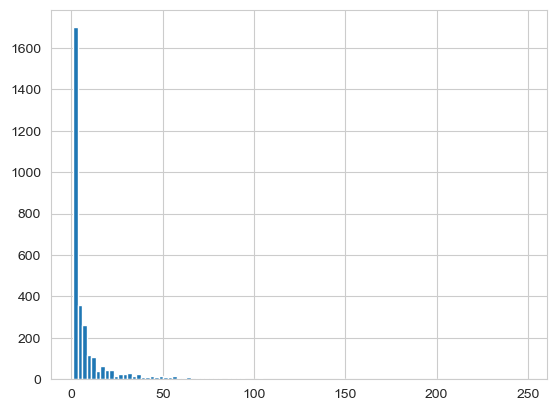

In [9]:
degrees = [g.degree(n) for n in g.nodes()]
plt.hist(degrees, bins=100);

In [10]:
n_nodes = len(g.nodes)
deg_centrality = []
for node in g.nodes():
    deg_centrality.append((node, deg[node]/(n_nodes-1)))
    
airport_deg_centrality = (pd.DataFrame(deg_centrality, columns=["airport", "degree_centrality"])
                            .sort_values(by="degree_centrality", ascending=False)
                            .reset_index()
                            .drop("index", axis=1))
airport_deg_centrality.head(10)

,airport,degree_centrality
0,AMS,0.079284
1,FRA,0.078005
2,CDG,0.076726
3,IST,0.074488
4,ATL,0.069373
5,ORD,0.065857
6,PEK,0.065537
7,MUC,0.061381
8,DFW,0.060102
9,DME,0.059783


In [11]:
d100 = [n for n in g.nodes if deg[n] > 100]
sg = g.subgraph(d100)

In [12]:
pos_dict = dict(
    zip(airport_keys,
        [(x, y) for x, y in zip(airport_df.latitude, airport_df.longitude)]))

m = folium.Map(location=[30, 31], zoom_start=3)

for (node, attrs) in sg.nodes(data=True):
    attrs["pos"] = pos_dict[node]

for (node, attrs) in sg.nodes(data=True):
    node_feature_group = folium.FeatureGroup(name=node)
    folium.CircleMarker(location=attrs['pos'],
                        color="blue",
                        opacity=1,
                        popup=str(node),
                        size=np.log(deg[node])).add_to(node_feature_group)
    for edge in sg.edges():
        source_node, dest_node = edge
        source_coord = sg.nodes[source_node]['pos']
        dest_coord = sg.nodes[dest_node]['pos']
        if dest_node == node:
            folium.PolyLine(locations=[source_coord, dest_coord],
                            color='green',
                            dash_array='3',
                            opacity=0.25,
                            width=1,
                            popup=str(source_node) + " -> " + str(dest_node)
                           ).add_to(node_feature_group)

    node_feature_group.add_to(m)

folium.LayerControl().add_to(m)
m.save(os.getcwd()+"/output/flight_network.html")

## China

In [13]:
chinese_airport_ids = airport_df[airport_df.country == "China"]["airport_id"].tolist()

In [14]:
for col in ["source_airport_id", "destination_airport_id"]:
    route_df[col] = route_df[col].astype(int)

china_routes = (route_df[route_df.source_airport_id.isin(chinese_airport_ids)
             & route_df.destination_airport_id.isin(chinese_airport_ids)]
               .reset_index()
               .drop("index", axis=1))
china_routes.head(5)

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,stops,source_geom,destination_geom,distance
0,3U,4608,BHY,6351,XIY,3379,0,POINT (109.293999 21.5394),POINT (108.751999 34.447102),1436.249486
1,3U,4608,CAN,3370,CKG,3393,0,POINT (113.29900360107422 23.39240074157715),POINT (106.64199829101562 29.719200134277344),965.640891
2,3U,4608,CAN,3370,CTU,3395,0,POINT (113.29900360107422 23.39240074157715),POINT (103.9469985961914 30.578500747680664),1222.628408
3,3U,4608,CGO,3375,CGQ,4380,0,POINT (113.841003418 34.519699096699995),POINT (125.684997559 43.9962005615),1463.435352
4,3U,4608,CGO,3375,CKG,3393,0,POINT (113.841003418 34.519699096699995),POINT (106.64199829101562 29.719200134277344),862.449335


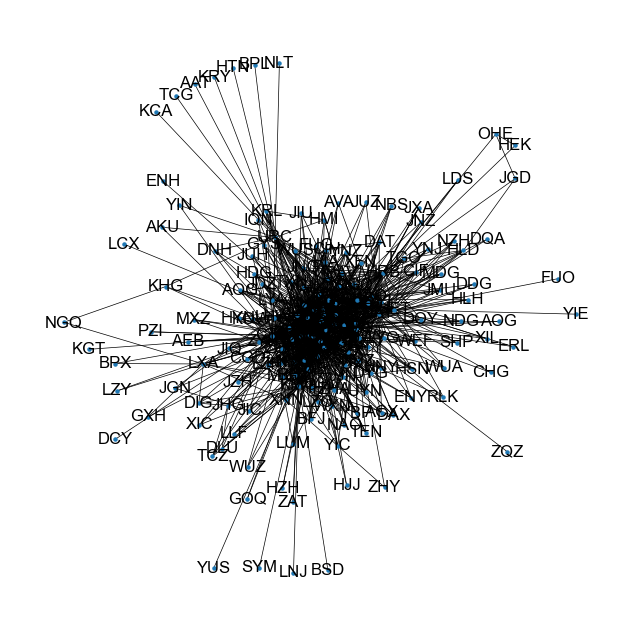

In [15]:
gc = nx.from_pandas_edgelist(china_routes,
                             source="source_airport",
                             target="destination_airport",
                             edge_attr="distance")
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pos = nx.spring_layout(gc, iterations=100)
nx.draw_networkx(gc, ax=ax, pos=pos,
                 with_labels=True, node_size=5, width=.5)
ax.set_axis_off()

In [16]:
low_degree = [n for n, d in gc.degree() if d < np.mean([d for n, d in gc.degree()])]
gc.remove_nodes_from(low_degree)

components = nx.connected_components(gc)
largest_component = max(components)
H = gc.subgraph(largest_component)

btw_centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

In [17]:
pos_df = airport_df[airport_df.iata.isin(H.nodes())][["iata", "longitude", "latitude"]].set_index("iata")
pos = {idx: pos for idx, pos in zip(pos_df.index, pos_df.to_numpy())}

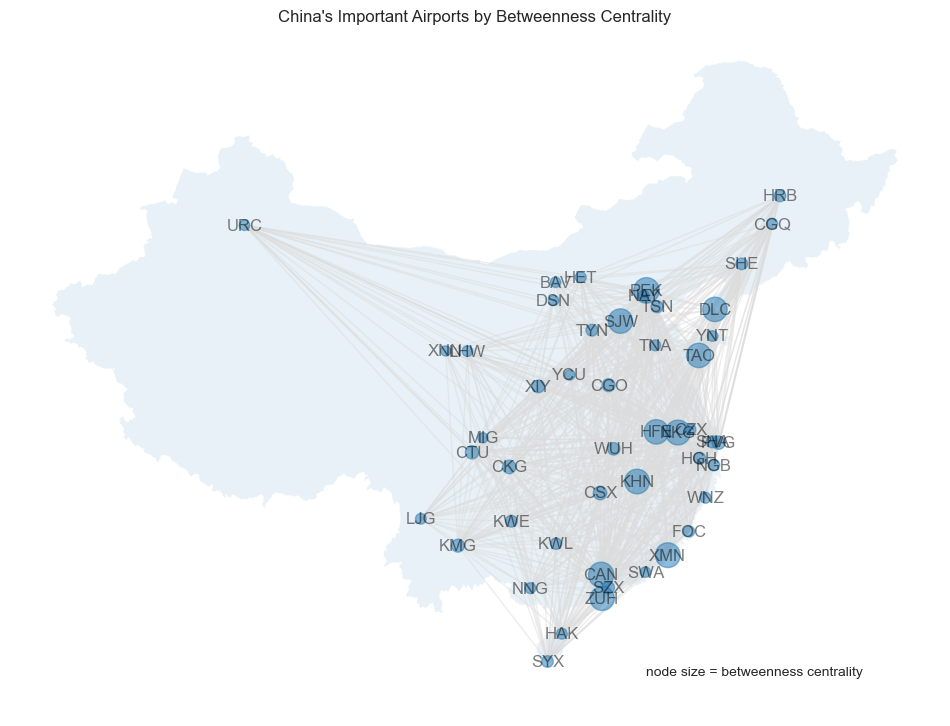

In [18]:
china = gpd.read_file(os.getcwd()+"/data/china_boundary.zip")
fig, ax = plt.subplots(figsize=(12, 12))
china.plot(ax=ax, alpha=0.1);
node_size = [v * 2500 for v in btw_centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=True,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.5,
    ax=ax,
)
ax.text(
    0.80,
    0.06,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
)
ax.set_axis_off()
plt.title("China's Important Airports by Betweenness Centrality")
plt.show()
fig.savefig(os.getcwd()+"/output/china_btw_airports", dpi=400)

## Shortest Path

In [19]:
# create a graph with distance
gwd = nx.from_pandas_edgelist(route_df,
                              source="source_airport",
                              target="destination_airport",
                              edge_attr="distance",
                              create_using=nx.DiGraph())
p = nx.shortest_path(gwd, weight="distance")

In [20]:
# Suppose I want to travel from DC (DCA/IAD/BWI) to Xi'an (XIY)
# A non-updated flight schedule around early 2010s
print("To XIY \nStarts from DCA: {} \nStarts from IAD: {} \nStarts from BWI: {}".format(
    p["DCA"]["XIY"], p["IAD"]["XIY"], p["BWI"]["XIY"]))

print("From XIY \nTO XIY: {} \nTO IAD: {} \nTO BWI: {}".format(
    p["XIY"]["DCA"], p["XIY"]["IAD"], p["XIY"]["BWI"]))

To XIY 
Starts from DCA: ['DCA', 'YYZ', 'PEK', 'XIY'] 
Starts from IAD: ['IAD', 'PEK', 'XIY'] 
Starts from BWI: ['BWI', 'YYZ', 'PEK', 'XIY']
From XIY 
TO XIY: ['XIY', 'PEK', 'YYZ', 'DCA'] 
TO IAD: ['XIY', 'PEK', 'IAD'] 
TO BWI: ['XIY', 'PEK', 'YYZ', 'BWI']


## Structural Hole to flight network

In [21]:
gc_sh = nx.from_pandas_edgelist(china_routes,
                                source="source_airport",
                                target="destination_airport",
                                edge_attr="distance",
                                create_using=nx.DiGraph())
sh = nx.constraint(gc_sh)

In [22]:
pos_df_sh = airport_df[airport_df.iata.isin(gc_sh.nodes())][["iata", "longitude", "latitude"]].set_index("iata")
pos_sh = {idx: pos for idx, pos in zip(pos_df_sh.index, pos_df_sh.to_numpy())}

In [23]:
sh_df = (pd.DataFrame(sh, index=[0]).T.reset_index().rename(
    {
        "index": "airport",
        0: "constraint_val"
    }, axis=1))

sh_thres = sh_df["constraint_val"].quantile(0.05)

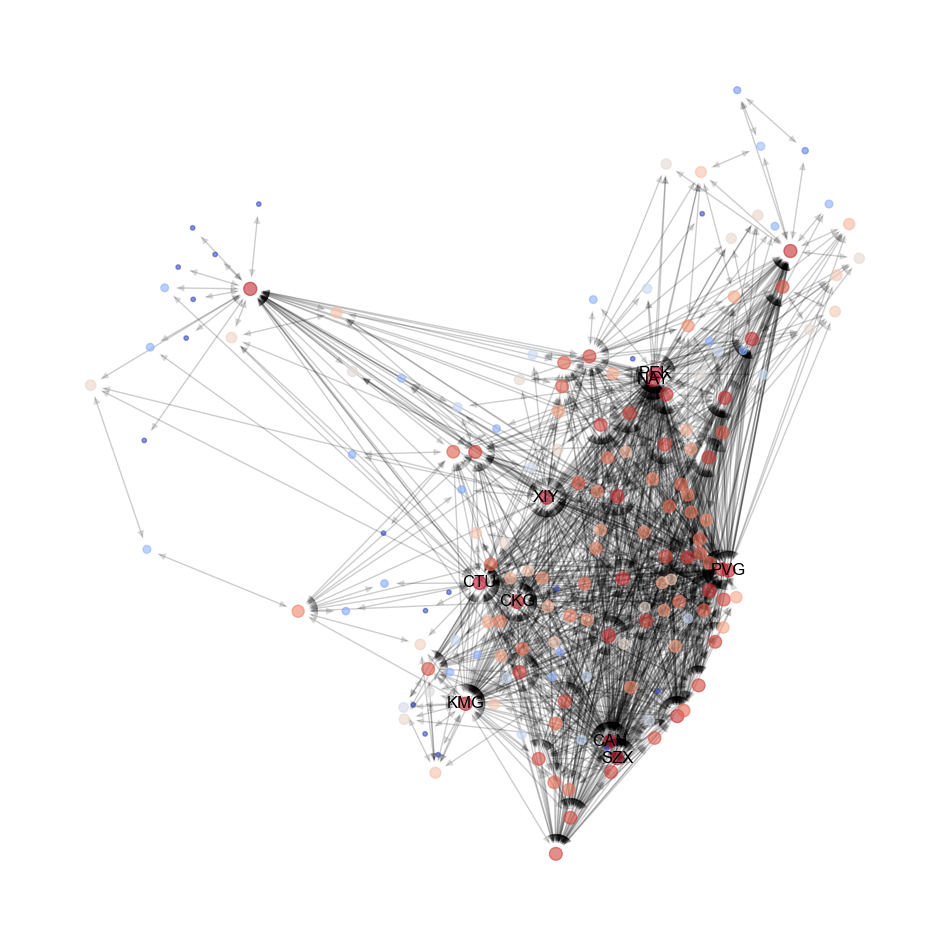

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))
node_size = np.array([1 - val for val in sh.values()])
node_size = 10**(node_size + 1)

nx.draw_networkx_nodes(gc_sh,
                       ax=ax,
                       pos=pos_sh,
                       node_color=node_size,
                       cmap=plt.cm.coolwarm,
                       node_size=node_size,
                       alpha=0.6)
nx.draw_networkx_edges(gc_sh, pos=pos_sh, alpha=0.1, ax=ax)

# Only display 
labels = {}
for node, node_size in sh.items():
    if node_size < sh_thres:
        labels[node] = node
nx.draw_networkx_labels(gc_sh, pos=pos_sh, labels=labels)
ax.set_axis_off()
fig.savefig(os.getcwd()+"/output/china_airhub_network", dpi=400)